<a href="https://colab.research.google.com/github/yqwang1/Computational_Neuro/blob/main/Temporal_coding_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download the class data and library

!git clone https://github.com/kdharris101/NeuralCodingClass.git

Cloning into 'NeuralCodingClass'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 295 (delta 1), reused 18 (delta 1), pack-reused 277 (from 1)
Receiving objects: 100% (295/295), 391.36 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (268/268), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

import NeuralCodingClass.neurocode as nc

In [ ]:
# load the data
FileDir = r'NeuralCodingClass/data/bush'
Experiment = 'Patient1Session1'

spikes=nc.load_object(os.path.join(FileDir, Experiment, 'spikes'))
stims=nc.load_object(os.path.join(FileDir, Experiment, 'stims'))
stims.frames = stims.frames.astype(int) # correct datatype
spikes.clusters = spikes.clusters.astype(int) # correct datatype


In [ ]:
# we have loaded two data objects as a "Bunch", a simple datastructure which
# contains many arrays, all with the same number of rows.

# spikes has one row per spike
# stims has one row per stimulus.

# let's see what's in it:

for k in spikes.keys():
  print(f'spikes.{k:<20}: size {spikes[k].shape}\t dtype {spikes[k].dtype}')

for k in stims.keys():
  print(f'stims.{k:<20}: size {stims[k].shape}\t dtype {stims[k].dtype}')



spikes.times               : size (4668,)	 dtype float64
spikes.clusters            : size (4668,)	 dtype int64
stims.frames              : size (300,)	 dtype int64
stims.intervals           : size (300, 2)	 dtype float64


**Here's what the arrays contain:**

spikes.times: time of each spike (seconds)

spikes.clusters: neuron assignment of each spike (int)

stims.intervals: start and stop time of each stimulus trial (seconds)

stims.frames: which stimulus was shown on each trial (int)

In [ ]:
# now we are going to count how many spikes each neuron fired following each
# stimulus presentation. This uses one function from the neurocode library
# (made for this class), and one from numpy.
#
# nc.find_close_pairs finds all spike-stimulus pairs for which the spike is at
# most 1s after the stimulus.
#
# np.histogram2d is built in to numpy and makes a 2d array counting the spikes of
# each cell after each stimulus.
#
# this output is put in stims.spike_counts, of size nStims x nClusters.
# keeping with our convention that all arrays in a Bunch have the same length
# of their first dimension (here the number of stimulus presentations)
#
# a "cluster" means a putative neuron as inferred because the spikes all have
# a similar shape.

nStims = len(stims)
nClusters = spikes.clusters.max().astype(int)+1
nFrames = stims.frames.max().astype(int)+1
nRepeats = 6
print('%d clusters'%nClusters)



8 clusters


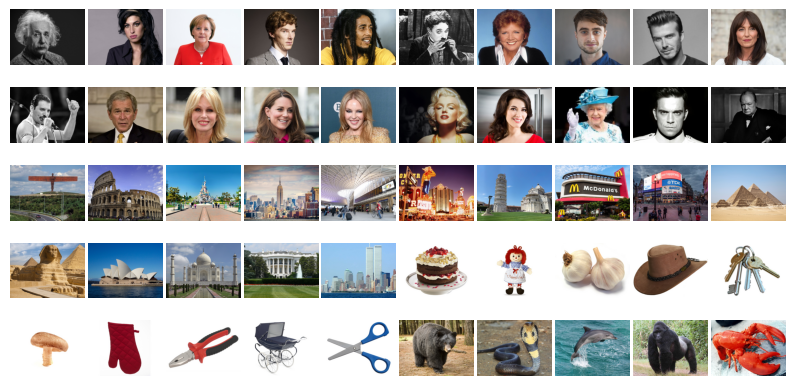

In [ ]:
# Now let's view all the stimuli, which are stored as additional files
# we just load them in and plot them

fig, ax = plt.subplots(5,10,figsize=(10,5), sharex=True, sharey=True, gridspec_kw={'wspace':.05, 'hspace':.05})
for i in np.arange(nStims):
    plt.sca(ax.flat[i])
    im = np.load(os.path.join(FileDir, Experiment, 'Image%03d.npy'%i))
    plt.imshow(im, cmap='gray',vmin=0,vmax=255)
    plt.axis('off')

In [ ]:
# pre-processing of spikes array

# make spike count array, counting for 1s after stimulus onset for each stimulus (they lasted 1s)

# a spike will be counted as belonging to stimulus s if it lies between
# win_start and win_end following that stimulus' onset
win_start = 0
win_end = 1
pairs = nc.find_close_pairs(spikes.times, stims.intervals[:,0]+win_start, 0, win_end-win_start)

stims.spike_counts,_,_ = np.histogram2d(pairs[:,1], spikes.clusters[pairs[:,0]],
                    bins=[np.arange(len(stims)+1), np.arange(nClusters+1)]
                          )

# find the repeat # for each stimulus
stims.repeats = np.zeros(len(stims))
for f in np.arange(nFrames):
  stims.repeats[stims.frames==f] = np.arange(nRepeats)

# spikes_in_stims is a Bunch with one entry per spike that is in a stimulus presentation
spikes_in_stims = spikes.select(pairs[:,0])
spikes_in_stims.spikes = pairs[:,0] # index to original spike number
spikes_in_stims.stims = pairs[:,1] # index to stimulus number
spikes_in_stims.pst = spikes_in_stims.times - stims.intervals[spikes_in_stims.stims,0] # peristimulus time
spikes_in_stims.frames = stims.frames[spikes_in_stims.stims] # image presented for this spike
spikes_in_stims.repeats = stims.repeats[spikes_in_stims.stims] # repeat number of this image




Now let's plot rasters for our example cells and rasters after time shuffling.

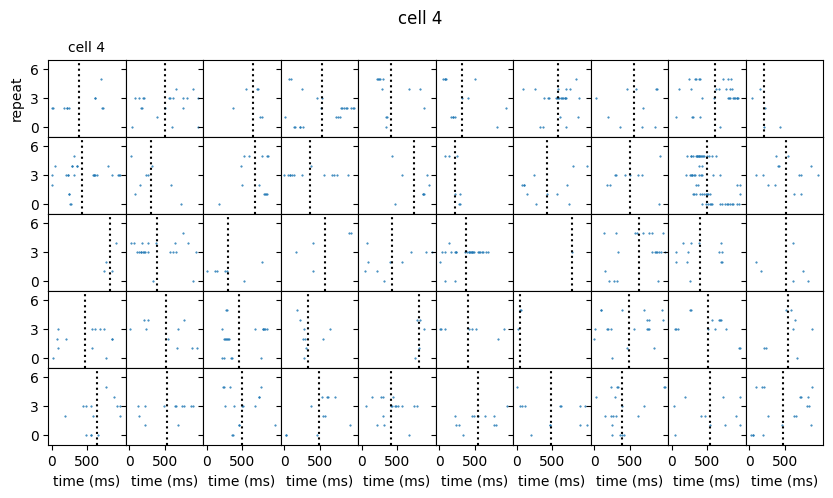

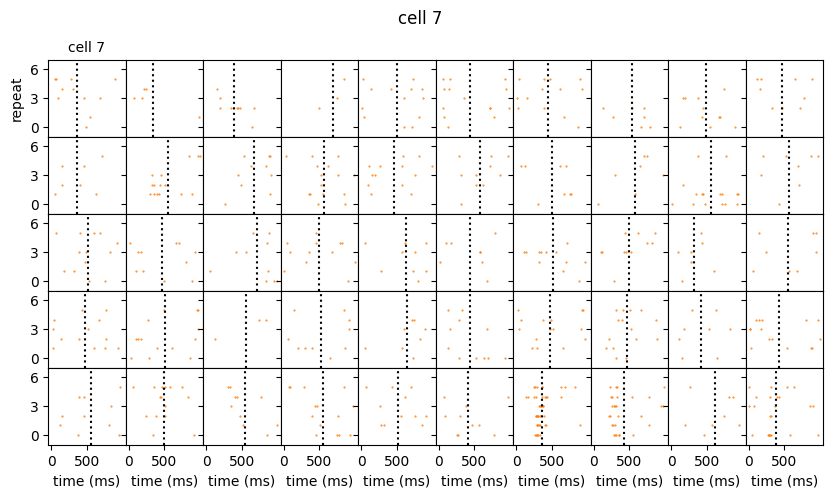

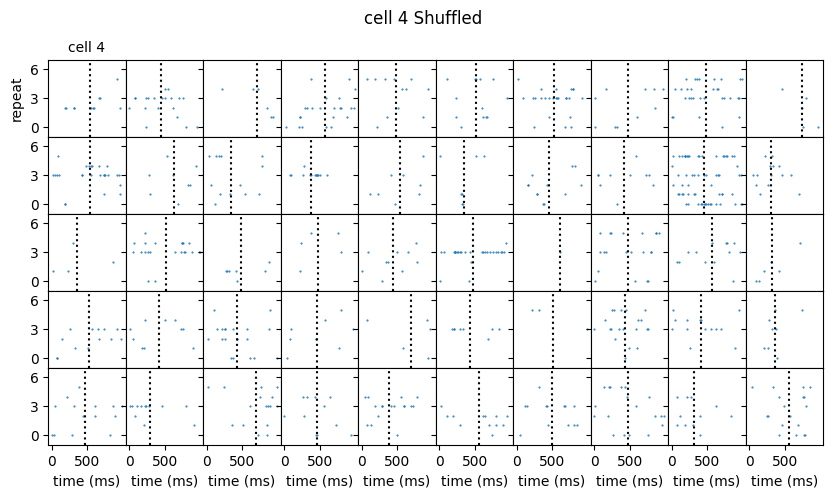

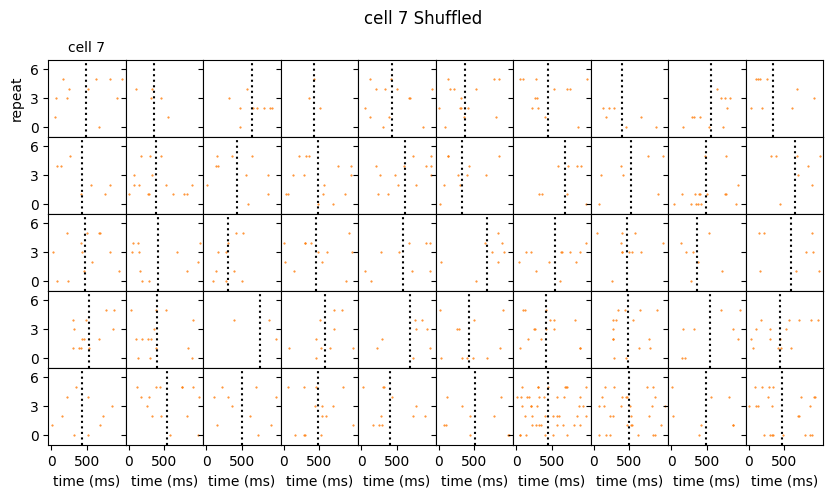

In [ ]:
ExampleCells=[4,7] # these are the concept cells
ExampleColors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(ExampleCells)]

for shuf in [False, True]:
    for c, color in zip(ExampleCells, ExampleColors):

        fig, ax = plt.subplots(5,10,figsize=(10,5),
                               sharex=True, sharey=True, gridspec_kw={'wspace':.0, 'hspace':.0})
        for f in np.arange(nFrames):

            plt.sca(ax.flat[f]) # choose current subplot

            # to make raster in ms, multiply times by 1000

            if shuf:
              cell_pst = np.random.permutation



            cell_spks = spikes_in_stims.clusters==c
            cell_rpt = spikes_in_stims.repeats[cell_spks]
            if shuf:
                cell_pst = np.random.permutation(spikes_in_stims.pst[cell_spks])
            else:
                cell_pst = spikes_in_stims.pst[cell_spks]

            my_cell_spks = (spikes_in_stims.frames[cell_spks]==f)

            plt.plot(cell_pst[my_cell_spks]*1000, cell_rpt[my_cell_spks],
                     '.', color=color, markersize=1)

            plt.xticks(np.linspace(0,500,2))
            plt.yticks(np.linspace(0,6,3))
            plt.ylim([-1,7])
            plt.xlabel('time (ms)')
            if f==0: plt.ylabel('repeat'); plt.title('cell %d'%c, fontsize=10)
            plt.gca().label_outer()



            # now make mean stim time
            mean_time = np.mean(cell_pst[my_cell_spks])
            plt.axvline(mean_time*1000, color='k', linestyle=':')


            #plt.title('stim %d'%i, fontsize=10)
            plt.gca().label_outer()
            plt.suptitle('cell %d %s'%(c, 'Shuffled' if shuf else ''))

QUESTION: Looking at these rasters, does it look like there is temporal coding?  

EXERCISE: make the same plots for all cells.  Are there any cases where it looks like there is temporal coding without rate coding?

In [ ]:
# Answer goes here ...

Cell 4 p= 0.001
Cell 7 p= 0.54


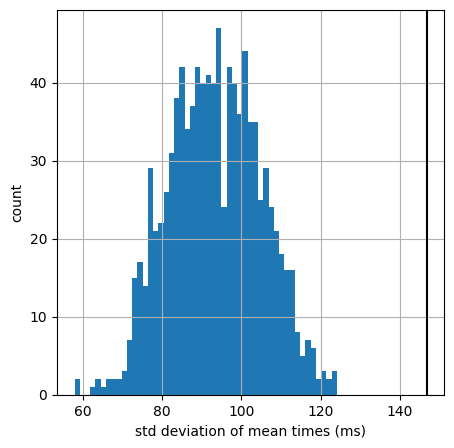

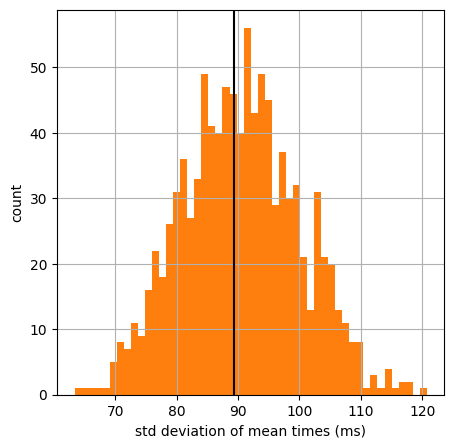

In [ ]:
# Next,  we will do a significance test to see which cells significantly temporally
# the stimuli

for c, color in zip(ExampleCells, ExampleColors):
    plt.figure(figsize=(5,5))
    my = (spikes_in_stims.frames>=0) & (spikes_in_stims.clusters==c)

    n_spk = np.bincount(spikes_in_stims.frames[my])
    sum_times = np.bincount(spikes_in_stims.frames[my], spikes_in_stims.pst[my])

    mean_times = sum_times/n_spk
    test_stat = np.nanstd(mean_times)

    N=999
    null = np.zeros(N)
    for i in range(N):
        rand_sum_times = np.bincount(spikes_in_stims.frames[my], np.random.permutation(spikes_in_stims.pst[my]))
        rand_mean_times = rand_sum_times/n_spk
        null[i] = np.nanstd(rand_mean_times)

    plt.hist(null*1000,50, color=color)
    plt.axvline(test_stat*1000, color='k')

    #plt.xlim([0, 30])
    #plt.xticks(np.linspace(0,30,7))
    plt.xlabel('std deviation of mean times (ms)')
    plt.ylabel('count')
    plt.grid(True)

    print('Cell', c, 'p=', (1+np.sum(null>=test_stat))/(N+1))


EXERCISE: run this again after changing win_start to 0.2 and win_end to 0.7.

What changes?  Why? Which analysis is more valid